In [1]:
#Excluding warnings 
import warnings
warnings.filterwarnings('ignore')

#Importing necessary data preprocessing/visualization libraries...
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#... and necessary ML stuff 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, plot_roc_curve, f1_score
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [2]:
#Defining constant variables that I will use throughout the project

RANDOM_STATE = 17

In [3]:
#Drawing decision trees

import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.core.display import HTML 

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)


# Part I // 'Out-of-the-box'

In [4]:
#Importing the data

train_df = pd.read_csv('data/flight_delays_train.csv.zip')
test_df = pd.read_csv('data/flight_delays_test.csv.zip')

In [5]:
#Checking if everything loaded fine
train_df.shape, test_df.shape

((100000, 9), (100000, 8))

In [6]:
train_df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier',
       'Origin', 'Dest', 'Distance', 'dep_delayed_15min'],
      dtype='object')

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.9+ MB


There are no missing values! Let's see first few rows of our data:

In [8]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [9]:
train_df['dep_delayed_15min'].value_counts(normalize = True)

N    0.80956
Y    0.19044
Name: dep_delayed_15min, dtype: float64

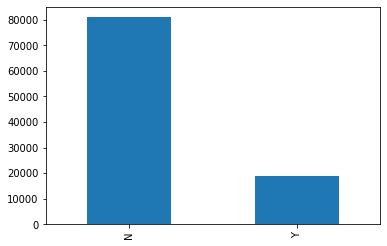

In [10]:
train_df['dep_delayed_15min'].value_counts().plot(kind = 'bar', );

Obviously, target labels are skewed (imbalanced) but not too imbalanced relatively speaking.

# Data preprocessing

In [11]:
#Spliting the train part into matrix of features and vector of labels

X_train = train_df.drop(columns = ['dep_delayed_15min'])
y_train = train_df['dep_delayed_15min']

In [12]:
X_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


In [13]:
X_train.iloc[0:5]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


## Stage 1

We see that it is worth performing a cleaning part of the categorical features that corresponds to 'date' (Month, DayofMonth and DayOfWeek), and converting them to integer values. I will also keep the original ones just in case that I missed something. At this point it would also be a nice idea to concatenate train and test dataset in order to clean data 'all at once'.

In [14]:
#Both train and test part have 10000 samples, but I will keep the location of the X_train
TRAIN_LOC = 99999

X_test = test_df
X = pd.concat([X_train, X_test], ignore_index = True)

In [15]:
#Let's test if everything is fine 
X.shape

(200000, 8)

In [16]:
X.tail()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
199995,c-6,c-5,c-2,852,WN,CRP,HOU,187
199996,c-11,c-24,c-6,1446,UA,ORD,LAS,1515
199997,c-1,c-30,c-2,1509,OO,ORD,SGF,438
199998,c-1,c-5,c-5,804,DL,LGA,ATL,761
199999,c-10,c-29,c-1,834,OO,MKE,MSP,297


In [17]:
#Cleaning the collumns for unnecessary 'c-' part

X['Month_1'] = np.array([value[2:] for value in X['Month'].values]).astype('int')
X['DayOfMonth_1'] = np.array([value[2:] for value in X['DayofMonth'].values]).astype('int')
X['DayOfWeek_1'] = np.array([value[2:] for value in X['DayOfWeek'].values]).astype('int')

In [18]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Month_1,DayOfMonth_1,DayOfWeek_1
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,7
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,3
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,5
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,6
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,6


## Stage 2

One can also see that we need to convert categorical features UniqueCarrier, Origin and Dest into something that is understandable for ML algorithms. I will convert those via LabelEncoding, but I will also keep a copy of current dataset since **catboost** classifier has some implicit ways of dealing with categorical variables which makes it more powerful than other libreries which train Gradient Boosted trees. There might be a possibility that I will also use something more sophisticated afterwards for encoding.

In [19]:
#Keep the copy of current dataset
X_cat = X.copy()

#Encoding 'UniqueCarrier', 'Origin' and 'Dest'
le = LabelEncoder()
columns_le = ['UniqueCarrier', 'Origin', 'Dest']

for column in columns_le:
    le.fit(X[column])
    X[column+str('_1')] = le.transform(X[column]).astype('int')

In [20]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,7,1,19,82
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,3,19,226,180
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,5,21,239,62
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,6,16,81,184
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,6,20,182,210


## Stage 3

I will treat DepTime and Distance as floats, because there might be some future operations with these features that would help me in feature engineering. 

In [21]:
X['DepTime_1'] = X['DepTime'].astype('float64')
X['Distance_1'] = X['Distance'].astype('float64')

In [22]:
X.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1,DepTime_1,Distance_1
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,8,21,7,1,19,82,1934.0,732.0
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,4,20,3,19,226,180,1548.0,834.0
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,9,2,5,21,239,62,1422.0,416.0
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,11,25,6,16,81,184,1015.0,872.0
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,10,7,6,20,182,210,1828.0,423.0


## Stage 4

At this point I think all the necessary preprocessing is more or less considered to be done, and now I am safe to remove 'old' features, for now.

In [23]:
#Using a trick to find all the columns I need to drop
cols_del = train_df.columns.drop('dep_delayed_15min')

In [24]:
X.drop(columns = cols_del, inplace = True)

In [25]:
X.head()

,Month_1,DayOfMonth_1,DayOfWeek_1,UniqueCarrier_1,Origin_1,Dest_1,DepTime_1,Distance_1
0,8,21,7,1,19,82,1934.0,732.0
1,4,20,3,19,226,180,1548.0,834.0
2,9,2,5,21,239,62,1422.0,416.0
3,11,25,6,16,81,184,1015.0,872.0
4,10,7,6,20,182,210,1828.0,423.0


## Stage 5

One last piece is to map target variables to 0s and 1s.

In [26]:
#Map target feature to {0,1}

mapping = {'N': 0, 'Y': 1}
y = train_df['dep_delayed_15min'].map(mapping)

In [27]:
#Re-split the data temporarly into train and test set
train_data = X[:(TRAIN_LOC+1)]

#Split the training data into train and validation part
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y,\
                                                      test_size=0.3, random_state = RANDOM_STATE,\
                                                      shuffle = True)

In [28]:
#Check if everything is correct

X_train.shape, X_valid.shape, y_train.shape[0], y_valid.shape[0]

((70000, 8), (30000, 8), 70000, 30000)

Time for ML! 

# Decision Trees

In my usual practise I tend to start with the simplest models and see if they yield meaningful results. I consider Decision Trees, Logistic Regression and kNN as simple models.

From there I can make a decision such as if linear models have a better perfomance over tree based models, which (usually) means that data is more linearly separable (if you think about it). 

Second, it is also a good compass to see if it's meaningful to use complex variants based on a simpler models (DecisionTrees -> RandomForest -> BoostedTrees). Or maybe the ensemble of them would work even better?

There are more dimensions in a domain of business than just binary dimension 'isAlgoFancy'. Time of evaluating predictions might be one of the crucial parameters in determining if one should use 'less better model' over 'fancy ones', and it could be also stated explicitly in some metric!

In [29]:
#Train vanilla decision tree without any hyperparameter tuning

dt = DecisionTreeClassifier(random_state = RANDOM_STATE)

In [30]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=17, splitter='best')

In [31]:
dt_preds = dt.predict(X_valid)
dt_acc_score = accuracy_score(dt_preds, y_valid)
dt_roc_auc_score = roc_auc_score(dt_preds, y_valid)

In [32]:
print(f'Accuracy score using plain DecisionTreeClassifier: {round(dt_acc_score, 5)}')
print(f'ROC-AUC score using plain DecisionTreeClassifier: {round(dt_roc_auc_score, 5)}')

Accuracy score using plain DecisionTreeClassifier: 0.7279
ROC-AUC score using plain DecisionTreeClassifier: 0.56859


Bear in mind that we used each feature in this out-of-the-box DecisionTree, and without doing any EDA. Second, the data is relatively speaking imbalanced, so using 'stratified samples' is **a must.** Not only that, we even randomly shuffled the data! Our ROC-AUC is slightly better than 'random guessing', and Boosting says that given a model that is slightly better than random guessing it's true you can make it a strong learne. 

Finaly, let's compare our model to the baseline: **predict all that are non delayed** model.

In [33]:
train_df['dep_delayed_15min'].value_counts(normalize = True)

N    0.80956
Y    0.19044
Name: dep_delayed_15min, dtype: float64

The share of non-delayed airplaines in the sample is around 80%. The most naive model that always predicts a "loyal customer" on such data will guess right in about 80% of all cases. That is, the proportion of correct answers (accuracy) of subsequent models should be no less than this number, and will hopefully be significantly higher.

### DecisionTree (GridSearchCV - Accuracy)

Let's tune a decision tree and see if it makes any significant progress in terms of ROC/AUC. We will also use StratifiedKFold cross-validation to ensure that we have equal proportions of labels in each split.

In [34]:
#Defining hyperparameters for tuning a decision tree
tree_params = {'max_depth': range(2, 11), 
               'min_samples_leaf' : range(2,11),
               } #'max_features': range(2, len(X.columns)+1) could be used here

#Defining 5-fold stratified cross-validation scheme
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

In [35]:
#Using GridSearchCV to test all possible permutations of tree_params to find the optimal score on validation set
tree_grid = GridSearchCV(estimator = dt, scoring = 'accuracy',  param_grid = tree_params, cv = skf, n_jobs = -1)

In [36]:
%%time
tree_grid.fit(X_train, y_train)

CPU times: user 1.59 s, sys: 403 ms, total: 1.99 s
Wall time: 9.19 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
            

In [37]:
#Printing best parameters found by cross-validation
tree_grid.best_params_

{'max_depth': 8, 'min_samples_leaf': 8}

In [38]:
print(f'Best accuracy score on CV is: {round(tree_grid.best_score_, 5)}')

Best accuracy score on CV is: 0.81341


In [39]:
#Saving the tuned DT 
best_tree = tree_grid.best_estimator_ 

#Assesing validation score on tuned DT
dt_best_preds = best_tree.predict(X_valid)
dt_best_acc_score = accuracy_score(dt_best_preds, y_valid)
dt_best_roc_auc_score = roc_auc_score(dt_best_preds, y_valid)

print(f'Best accuracy score on a validation set using tuned decision tree {round(dt_best_acc_score, 5)}')
print(f'Best ROC/AUC score on a validation set using tuned decision tree {round(dt_best_roc_auc_score, 5)}')

Best accuracy score on a validation set using tuned decision tree 0.8135
Best ROC/AUC score on a validation set using tuned decision tree 0.68182


So, we see that our accuracy score and AUC score improved by tuning some of the Decision Tree hyperparameters. Maybe if we tuned it a little more (max_features etc.) we would obtain better results. Again, I have to point out that stratified CV is mandatory to give true evaluation in case of unbalanced datasets. Using 10 fold-CV would yield even better estimates of score that one should trust, but as you can see CV score and score on unseen validation set don't deviate too much. 

Let's see what features seem important according to best decision tree model!

In [40]:
#If interested, one can uncomment next line of code to inspect the splits made by trained decision tree, or 
#look into the git repository for .png file
#tree_graph_to_png(tree_grid.best_estimator_, X.columns, png_file_to_save='decision_tree.png')

In [41]:
#Saving all the features based of best gini coefficient (similar like information gain)
tree_features = pd.DataFrame(data = tree_grid.best_estimator_.feature_importances_,
                             index = X.columns,
                             columns = ['Importance'])

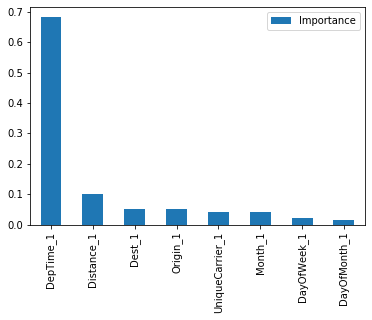

In [42]:
#Ploting the feature importances
tree_features.sort_values(by = 'Importance', ascending = False).plot(kind = 'bar');

Think of it, departure time being the most important feature even coincide with our own intuition as to why planes are delayed in a first place!

Same goes for the distance feature. Think of it, planes that go from point A to point B are always deviating in 'distance traveled' compared to expected 'shortest distance' from A to B, and hence some delay is mandatory. This also give us a nice idea to engineer a new feature such as combining Dest_1 and Origin_1.

Since Distance_1 has smaller feature importance (but significant than others) my hypothesis is that distances don't deviate from the expected one too much for this sample of datapoints, and (speaking of business side) we should take further focus on investigations in terms of departure time. 

We will evaluate feature importances for each model, possibly take an 'average decision' and see 'if everyone thinks the same'. 

Again, this dataset is **a sample** and these claims have to be further proved by statisticians in order to start taking further actions.

---

It is said that the model is stable if the standard deviation on validation set(s) (speaking of CrossValidation) is as less as possible. I will put the threshold and say that it should be strictly less than 0.5%.

In [43]:
#Defining 'mask' to filter out the best CV score
is_best_score = tree_grid.cv_results_['rank_test_score'] == 1 
best_score_test_std = tree_grid.cv_results_['std_test_score'][is_best_score][0]*100

In [44]:
print(f'Standard deviation defined as % on the best CV set is: {round(best_score_test_std, 3)}')

Standard deviation defined as % on the best CV set is: 0.046


In [45]:
best_score_test_std < 0.5

True

This means that CV test scores are distributed with very narrow (normal) distribution, and hence it is relatively precise measure of score expectation on our test-set. Affording CV with 10-folds would be even better for assesing true evaluation of models predictive power. 

Accuracy is not a good metric for imbalanced dataset, and hence we will move to ROC-AUC. 

### Decision Tree (GridSearchCV - ROC/AUC)

In [46]:
#Same parameters will be used to find the best DecisionTree but we are explicitly stating that we want ROC-AUC
#score to be improved via CV 
tree_grid_auc = GridSearchCV(estimator = dt, scoring = 'roc_auc',
                             param_grid = tree_params, cv = skf, n_jobs = -1)

In [47]:
%%time
tree_grid_auc.fit(X_train, y_train)

CPU times: user 1.15 s, sys: 617 ms, total: 1.77 s
Wall time: 7.62 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=17,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
            

In [48]:
tree_params

{'max_depth': range(2, 11), 'min_samples_leaf': range(2, 11)}

In [49]:
print(f'Best parameters based on CV: {tree_grid_auc.best_params_}')

Best parameters based on CV: {'max_depth': 6, 'min_samples_leaf': 2}


In [50]:
print(f'Best ROC/AUC score for the DecisionTreeClassifier is: {round(tree_grid_auc.best_score_, 5)}')

Best ROC/AUC score for the DecisionTreeClassifier is: 0.69656


In [51]:
dt_best_auc_pred = tree_grid.best_estimator_.predict(X_valid)

In [52]:
print(f'ROC/AUC score on validation set for the tuned DecisionTreeClassifier is: {round(roc_auc_score(dt_best_auc_pred, y_valid), 5)}')

ROC/AUC score on validation set for the tuned DecisionTreeClassifier is: 0.68182


To understand our model better, we need to look 'under the hood' and it's done via looking at a confusion matrix.

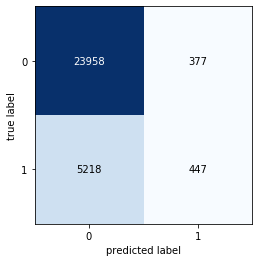

In [53]:
plot_confusion_matrix(confusion_matrix(y_valid, dt_best_auc_pred));

How much FPs, TPs, TNs and FNs one is able to tolerate depends on the bussines task/problem at hand. For example, to totally reduce the risk of an outbreak of some rare disease (COVID etc.) we would have to sacriface something in order to correctly find (classify) 'every' sample that is infected with COVID. When I say 'sacrifice something' it means that 'all' of the classification metrics depend directly by dialing-and-knobing TPs, TNs etc. where in a sense we can 'fight' some cases in favor of other, that is, make a 'trade-off'. 

Again, I will argue that in some business context you can't use AUC score to make something meaningful out of it. By improving AUC score we basically have some sort of a gauge to compare which classifier is better. As AUC score tends to 1 there is a 'better' freedom to make our model 'however we want', tolerating FPs and FNs by 'how much we want' and hence making the scores made out of those as 'idealy as we want'. I will argue that a probability one will encounter such a perfectly separable classes or to find that 'magic feature' that is 1:1 with target labels is very, very low. 

ROC curves are usually ploted as a False Positive Rate (x-axis) vs True Positive Rate (y-axis). 
By default, treshold probability 'isInClass' equals 0.5, and can vary from 0 to 1 and hence directly changing specificity and sensitivity.

One should always inspect a ROC curve by plotting all cases for FPR vs TPR since for example by having AUC = 0.8 it could mean different combinations of plots that have the same area under the curve around 0.8 (think of n different shapes that have the same area!). Bigger the dataset the more expensive is drawing ROC curves.

For the sake of convenience, and since our dataset is not very big let's plot it!

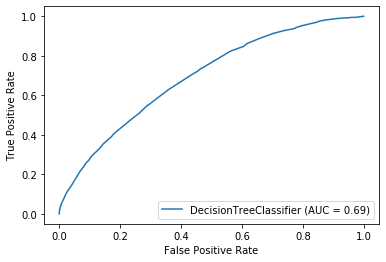

In [54]:
plot_roc_curve(estimator = tree_grid.best_estimator_, X = X_valid, y = y_valid);

These are usually hard to interpret since you can't see for which tresholds you will get such TPR and FPR. 
For this time being I will use the numbers from the previously obtained confusion matrix to estimate those. 

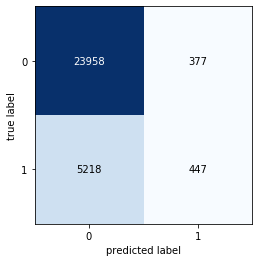

In [55]:
plot_confusion_matrix(confusion_matrix(y_valid, dt_best_auc_pred));

In [56]:
#When the probability treshold is 0.5 these are approximatevly the values for TPR and FPR
tpr_default_tresh = 447/y_valid.value_counts()[1] #TP/True (Actual) 'Yes'
fpr_default_tresh = 377/y_valid.value_counts()[0] # FP/True (Actual) 'No'

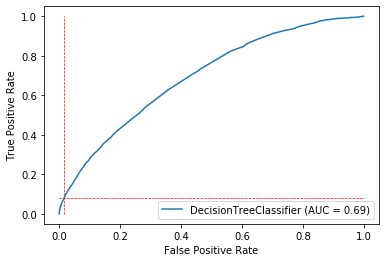

In [57]:
plot_roc_curve(estimator = tree_grid.best_estimator_, X = X_valid, y = y_valid)
plt.vlines(x = fpr_default_tresh, ymin = 0, ymax = 1, color = 'red', linestyle = '--', linewidth = 0.7);
plt.hlines(y = tpr_default_tresh, xmin = 0, xmax = 1, color = 'red', linestyle = '--', linewidth = 0.7);

We can observe that out of all 30000 samples in our validation set where 24335 belong to class 0 ('not-delayed') and 5665 belong to class 1 ('delayed') our classifier is relatively good at predicting labels 0 (True Negatives), which was expected. On the contrary, there are way too many False Negatives (5218 of them), and hence our model is very bad at predicting True Positives (447/5665).

This is why on imbalanced datasets accuracy is no way of measuring a success! Again, I have to mention that so far we haven't done any feature engineering, which might help us to improve these 'out of box' models (make 'cleaner separation' of classes).

# kNN (k-Nearest Neighbors)

Among all the simple models kNN is also on my check list since it sometimes outperforms tree-based methods and the dataset is not that big. I'm not claiming that I'm an expert on them but, I will skip explaining the inner workings and going to point out three, of which I think, are the crucial parts that need to be assesed:

1) For algorithms which are based on calculating the distance feature scaling is absolute necessity in order to exclude the possiblity of giving more weight based on one feature versus the others, eg. when one distribution is located in the vicinity of zero and does not go beyond (-1, 1) while the other’s range is on the order of hundreds of thousands.

2) There are no theoretical ways to choose the number of neighbors. It's done via cross-validation and (here) GridSearch,

3) Weights of neighbors (each neighbor may contribute different weights; for example, the further the sample, the lower the weight). In scikit-learn implementation you can either choose **uniform** (all points have the same weights) **distance** (the weight is inversely proportional to the distance from the test sample), or any other user-defined function. 

I will try to optimize it relative to ROC/AUC score, and see if it outperforms tuned DecisionTreeClassifier. 

### kNN (GridSearchCV - ROC/AUC)

In [58]:
#Define a kNN pipeline 
knn_pipe = Pipeline([('scaler', StandardScaler()), \
                     ('knn', KNeighborsClassifier(n_jobs=-1))]) 


#For the simplicity, tuning only number of neighbors
knn_params = {'knn__n_neighbors': range(1, 10)}

knn_grid = GridSearchCV(estimator = knn_pipe, param_grid = knn_params,
                        cv=5, n_jobs=-1, scoring = 'roc_auc')

In [59]:
%%time
knn_grid.fit(X_train, y_train)

CPU times: user 213 ms, sys: 39.1 ms, total: 252 ms
Wall time: 12.5 s


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=-1,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             

In [60]:
print(f'Best parameters based on CV: {knn_grid.best_params_}')
print(f'Best ROC/AUC based on CV: {round(knn_grid.best_score_,5)}')

Best parameters based on CV: {'knn__n_neighbors': 9}
Best ROC/AUC based on CV: 0.64253


In [61]:
knn_best_auc_pred = knn_grid.best_estimator_.predict(X_valid)
print(f'ROC-AUC score on validation set for the tuned kNN is: {round(roc_auc_score(knn_best_auc_pred, y_valid), 5)}')

ROC-AUC score on validation set for the tuned kNN is: 0.61265


Previously we've seen that ROC-AUC score on tuned DecisionTreeClassifier is 0.68182 which is less than kNNs. This is another clue that tree based methods might work better on this dataset, and we should expect better results on RandomForests, or eventualy by using GradientBoostedTrees. Lastly, we have to see if thay holds comparing to the linear models aka LogisticRegression. Let's take a look at what kind of mistakes kNN is making!

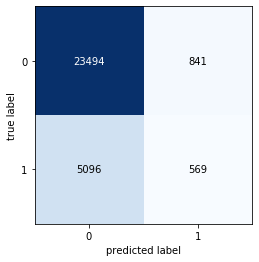

In [62]:
#kNN confusion matrix
plot_confusion_matrix(confusion_matrix(y_valid, knn_best_auc_pred));

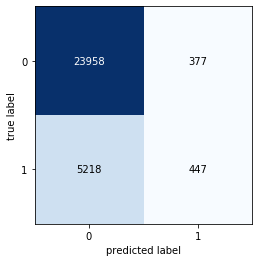

In [63]:
#Tuned DecisionTree confusion matrix
plot_confusion_matrix(confusion_matrix(y_valid, dt_best_auc_pred));

Wow, we immediately see that tuned kNN is better at predicting True Positives than tuned DecisionTree! But that is nothing to be compared to real problem where we expect to find even more!

--- 

Let's just imagine a buisness case scenario where it's crucial to predict those delayed flights because it costs us money. We have to improve True Positives in order to detect them better. The by-product of it is that we will (hopefully!) also improve our ROC-AUC score.

# Logistic Regression

**Strategy #1** 
We will start off by training plain LogisticRegression without any hyperparameter tuning, and by using it's own way of dealing with imbalanced data: parameter **class_weight** which in an essence puts weights on errors proportional to the class imbalance (errors on imbalanced class should be considered more costly than those of the other class). By putting **class_weight** to *balanced* it will weigh classes inversely proportional to their frequency. How good it works? That might be also considered as a hyperparameter to be tuned.

Just a quick thoughts on hyperparameter tuning. So far I've observed that LogisticRegression algos are not too sensitive to hyperparameter tuning. For my 'plain' LogisticRegression I will use 'lbfgs' solver since it is considered fastest and handles both L1 and L2 regularization, and max_iters will be set to 500 because if we use default one which is set to 100 there might be a convergence problem. Lastly, I will introduce the default regularization by setting the parameter C == 1. 

Parameter C is inversly proportional to the regularization coefficient (lambda) and hence gives a better idea what you are doing in terms of regularization when you make it less or larger than one. By default, scikit-learn implementation uses L2 regularization, and you can think of it intuitevely as constraining weights (and biases) to an imaginary hypersphere where C^2 would represent sort of a radius of that hypersphere. Imagining that hypersphere is located at the origin (0,0,...,0) and that minimum of a loss function is somewhere else one can intuitevly see that by making C larger you are letting the gradient descent algorithm to make steps closer to the minimum, and conversely by letting C<1 you are putting too much constraints on the learning parameters and hence preventing model to overfit. 

It is also convenient to use feature scaling when we are dealing with any type of linear classifiers which in an essence learn weights associated with each feature. We don't want to overemphasise some features over the others, that is, we want to put them on the same scale and hence we use StandardScaler (z-score). Another consequence of feature scaling is that it makes our 'loss function' more properly scaled which implies faster convergence towards local/global minimum. Lastly, it is used to make feature importance interpretable but we compare features in units of standard deviation! 

In [64]:
#Define LogisticRegression classifier
logit = LogisticRegression(random_state = RANDOM_STATE, solver = 'lbfgs', C = 1,
                           class_weight = 'balanced', max_iter = 500, penalty = 'l2')
#Create a data pipeline
logit_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('logit', logit)])

In [65]:
%%time
logit_pipe.fit(X_train, y_train)

CPU times: user 138 ms, sys: 4.89 ms, total: 143 ms
Wall time: 50.8 ms


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logit',
                 LogisticRegression(C=1, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=17,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [66]:
#Predictions on validation set
logit_val_preds = logit_pipe.predict(X_valid)

#Calcule accuracy score relative to target labels
logit_acc_score = accuracy_score(logit_val_preds, y_valid)

#Calculate ROC-AUC score relative to target labels
logit_roc_auc_score = roc_auc_score(logit_val_preds, y_valid)

In [67]:
print(f'Accuracy score using LogisticRegression: {round(logit_acc_score, 5)}')
print(f'ROC-AUC score using LogisticRegression: {round(logit_roc_auc_score, 5)}')

Accuracy score using LogisticRegression: 0.61993
ROC-AUC score using LogisticRegression: 0.58043


Let's plot the confusion matrices between non-optimized LogisticRegression, and tuned DecisionTree classifier:

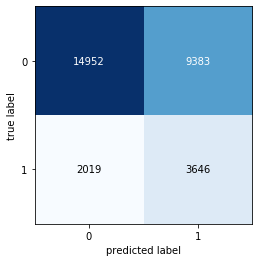

In [68]:
#LogisticRegressionClassifier confusion matrix
plot_confusion_matrix(confusion_matrix(y_valid, logit_val_preds));

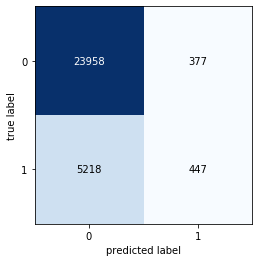

In [69]:
#Tuned DecisionTree confusion matrix
plot_confusion_matrix(confusion_matrix(y_valid, dt_best_auc_pred));

In [70]:
print(f'ROC-AUC score for tuned DecisionTreeClassifier is {round(roc_auc_score(dt_best_auc_pred, y_valid), 5)}, and for LogisticRegression {round(logit_roc_auc_score, 5)}.')

ROC-AUC score for tuned DecisionTreeClassifier is 0.68182, and for LogisticRegression 0.58043.


By setting the **class-weight** parameter to *balanced* we managed to detect far more True Positives than tuned DecisionTree classifier, but it has a consequence of having too many False Negatives! On the other hand non-optimized LogisticRegression has worse ROC-AUC score than tuned DecisionTreeClassifier which is again an indicator that we might make our further progress towards tree based methods, but first let us try to tune LogisticRegression!

### LogisticRegression (GridSearchCV - ROC-AUC/F1 score)

**Strategy #2** 
We have already seen that accuracy is not a good metric for imbalaced dataset, that is, it gives a false impression that we are doing 'good'.

Since I wanted to tackle improving ROC-AUC score (that is the Kaggle metric to improve upon in a first place!) in order to make this project more meaningful I will also think of it as solving our ficticious business case I've mentioned earlier (try to find as much True Positives such that FPs and FNs are balanced!) and try to improve ROC-AUC score by improving F1 score.

Why last statement makes sense? F1 score can be between 0 and 1. Let's think of an ideal case where F1 == 1. It means that Precision == Recall == 1. That is a case of **an ideal classifier**, and ROC-AUC in that case equals to 1! Remember that ROC curves are drawn such that x-axis represents FPR, and y-axis represents TPR. If Precision == 1, then there are no False Positives, and if Recall == 1 then there are no False Negatives. Since FPR = FP/True 'No', that means that FPR == 0. That is a point on a ROC curve such that (x, y) = (FPR, TPR) = (FPR, Recall) = (0, 1). You can obtain such point if and only if AUC == 1, and hence that is **an ideal classifier**! In a nutshell as F1 converges to 1, ROC-AUC should converge to 1. 

The F1 score is a metric that attempts to take that tradeoff between false positives, false negatives and  detected delayed flights, since it is calculted as harmonic mean between Precision and Recall. It is also worth noting that F1 score is a 'class' of F_beta scores where Precision and Recall are treated with the same weight. If one favours to improve Precision or Recall, other F_beta scores are used.

Another thing I want to tune is L2 regularization coefficient which in an essence tackles overfitting problem by making weights more constrained.

In [71]:
weights = np.linspace(0.05, 0.95, 20)

param_grid = {'logit__C': np.logspace(-3, 1, 10),
              'logit__class_weight': [{0: x, 1: 1.0-x} for x in weights]}
logit_grid = GridSearchCV(estimator = logit_pipe, scoring = 'f1', 
                          param_grid = param_grid, cv = skf, n_jobs = -1)

In [72]:
%%time
logit_grid.fit(X_train, y_train)

CPU times: user 3.92 s, sys: 2.54 s, total: 6.46 s
Wall time: 17 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('logit',
                                        LogisticRegression(C=1,
                                                           class_weight='balanced',
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=500,
                

In [73]:
#Best parameters 
logit_grid.best_params_

{'logit__C': 3.593813663804626,
 'logit__class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}}

In [74]:
print(f'Best F1 score based on cross-validation: {round(logit_grid.best_score_, 5)}')

Best F1 score based on cross-validation: 0.39546


In [75]:
logit_grid_preds = logit_grid.predict(X_valid)
print(f'ROC-AUC score based on cross-validation {round(roc_auc_score(logit_grid_preds, y_valid), 5)}')

ROC-AUC score based on cross-validation 0.58062


As I've already mentioned above, notice how LogisticRegression isn't that highly sensitive to tuning hyperparameters: ROC-AUC score is barely higher than plain LogisticRegression's.